### 결정 트리 모델의 시각화(Decision Tree Visualization)

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# DecisionTree Classifier 생성
dt_clf = DecisionTreeClassifier(random_state=156)

# 붓꽃 데이터를 로딩하고, 학습과 테스트 데이터 셋으로 분리
iris_data = load_iris()
X_train , X_test , y_train , y_test = train_test_split(iris_data.data, iris_data.target,
                                                       test_size=0.2,  random_state=11)

# DecisionTreeClassifer 학습. 
dt_clf.fit(X_train , y_train)

DecisionTreeClassifier(random_state=156)

In [2]:
from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함. 
export_graphviz(dt_clf, out_file="tree.dot", class_names=iris_data.target_names , \
feature_names = iris_data.feature_names, impurity=True, filled=True)

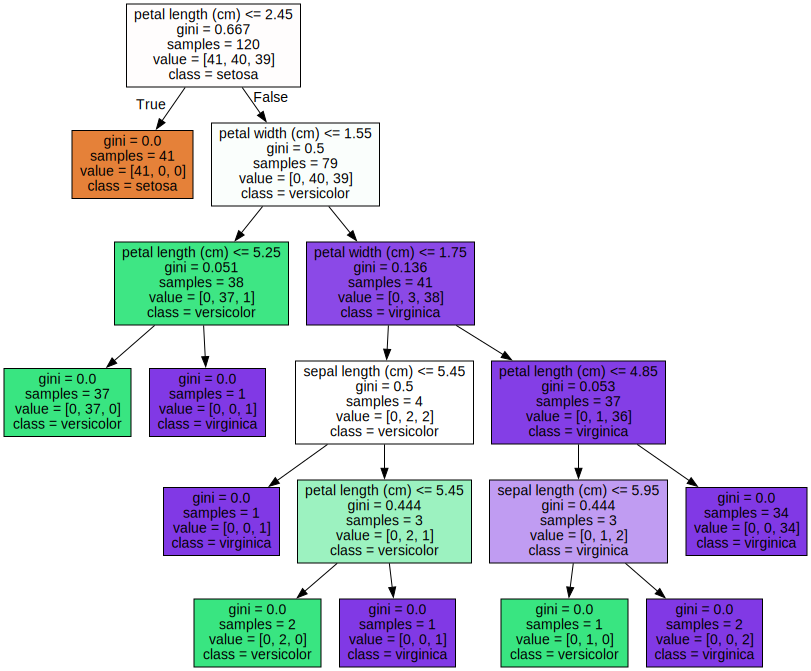

In [3]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
import seaborn as sns
import numpy as np
%matplotlib inline

# feature importance 추출 
print("Feature importances:\n{0}".format(np.round(dt_clf.feature_importances_, 3)))

# feature별 importance 매핑
for name, value in zip(iris_data.feature_names , dt_clf.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))

# feature importance를 column 별로 시각화 하기 
sns.barplot(x=dt_clf.feature_importances_ , y=iris_data.feature_names)


### 결정 트리(Decision TREE) 과적합(Overfitting)

In [ ]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("3 Class values with 2 Features Sample data creation")

# 2차원 시각화를 위해서 feature는 2개, 결정값 클래스는 3가지 유형의 classification 샘플 데이터 생성. 
X_features, y_labels = make_classification(n_features=2, n_redundant=0, n_informative=2,
                             n_classes=3, n_clusters_per_class=1,random_state=0)

# plot 형태로 2개의 feature로 2차원 좌표 시각화, 각 클래스값은 다른 색깔로 표시됨. 
plt.scatter(X_features[:, 0], X_features[:, 1], marker='o', c=y_labels, s=25, cmap='rainbow', edgecolor='k')

In [ ]:
import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 특정한 트리 생성 제약없는 결정 트리의 Decsion Boundary 시각화.
dt_clf = DecisionTreeClassifier(random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

In [ ]:
# min_samples_leaf=6 으로 트리 생성 조건을 제약한 Decision Boundary 시각화
dt_clf = DecisionTreeClassifier(min_samples_leaf=6, random_state=156).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

### 결정 트리 실습 - Human Activity Recognition

In [ ]:
# 예제 데이터 다운로드 링크
# https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])


**중복된 피처명을 확인**

In [ ]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

**원본 데이터에 중복된 Feature 명으로 인하여 신규 버전의 Pandas에서 Duplicate name 에러를 발생.**  
**중복 feature명에 대해서 원본 feature 명에 '_1(또는2)'를 추가로 부여하는 함수인 get_new_feature_name_df() 생성**

In [ ]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [ ]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [ ]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

In [ ]:
print(y_train['action'].value_counts())

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 예제 반복 시 마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train , y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [ 6, 8 ,10, 12, 16 ,20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)


In [ ]:
# GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성. 
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트(Evaluation)셋, 학습 데이터 셋의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]


In [ ]:
max_depths = [ 6, 8 ,10, 12, 16 ,20, 24]
# max_depth 값을 변화 시키면서 그때마다 학습과 테스트 셋에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth , accuracy))

In [ ]:
params = {
    'max_depth' : [ 8 , 12, 16 ,20], 
    'min_samples_split' : [16, 24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)


In [ ]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

In [ ]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()